In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys, torch, pickle, csv
import numpy as np
import scipy as sp
sys.path.append('/lfs/1/danfu/metal')
sys.path.append('/lfs/1/danfu/sequential_ws')
from metal.metrics import metric_score
from torch.nn.functional import normalize
from DP.label_model import *
import pandas as pd
import matplotlib.pyplot as plt

from metal.analysis import lf_summary
from metal.label_model.baselines import MajorityLabelVoter
from metal.label_model import LabelModel

# Train Metal LabelModel

In [3]:
L_train_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_train_100_windows_downsampled.npz'
L_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_val_windows_downsampled.npz'
Y_dev_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_val_windows_downsampled.npy'
L_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/L_test_windows_downsampled.npz'
Y_test_path = '/lfs/1/danfu/esper/app/data/shot_detection_weak_labels/Y_test_windows_downsampled.npy'

stride = 1
L_train = sp.sparse.load_npz(L_train_path).todense()[::stride]
L_dev = sp.sparse.load_npz(L_dev_path).todense()
Y_dev = np.load(Y_dev_path)
L_test = sp.sparse.load_npz(L_test_path).todense()
Y_test = np.load(Y_test_path)

In [4]:
label_model = LabelModel(k=2, seed=123)
label_model.train_model(L_train, class_balance=(0.15, 0.85), n_epochs=500, log_train_every=50)
label_model.score((L_dev, Y_dev), metric=['accuracy','precision', 'recall', 'f1'])

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.059]
[100 epo]: TRAIN:[loss=0.043]
[150 epo]: TRAIN:[loss=0.040]
[200 epo]: TRAIN:[loss=0.039]
[250 epo]: TRAIN:[loss=0.039]
[300 epo]: TRAIN:[loss=0.038]
[350 epo]: TRAIN:[loss=0.038]
[400 epo]: TRAIN:[loss=0.038]
[450 epo]: TRAIN:[loss=0.038]
[500 epo]: TRAIN:[loss=0.038]
Finished Training
Accuracy: 0.954
Precision: 0.943
Recall: 0.726
F1: 0.821
        y=1    y=2   
 l=1    199    12    
 l=2    75    1600   


[0.9538706256627784, 0.943127962085308, 0.7262773722627737, 0.8206185567010309]

# Tune Metal LabelModel

In [5]:
from metal.tuners.random_tuner import RandomSearchTuner
#label_model_everything_windows_tuned = LabelModel(k=2, seed=123)
random_tuner = RandomSearchTuner(LabelModel, seed=123, validation_metric='f1')

In [8]:
search_space = {
    'seed' : [123],
    'n_epochs': list(range(500, 2000, 100)),
    'lr': {'range': [1e-5, .1], 'scale': 'log'},
    'l2': {'range': [1e-5, .1], 'scale': 'log'},
    'log_train_every': [100],
    'class_balance': [
        (i * .1, 1 - i * .1)
        for i in range(1, 10)
    ]
#     'Y_dev': [Y_test_windows]
}

In [9]:
best_random_model = random_tuner.search(search_space,
                                (L_dev, Y_dev),
                               train_args= [L_train],
                               train_kwargs = {
#                                    'Y_dev': Y_test_windows
#                                    'class_balance': (0.2, 0.8)
                               },
                               init_kwargs={
                                   'k': 2
                               }, verbose=True)

[0] Testing {'seed': 123, 'n_epochs': 1700, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 1.6084800203002778e-05, 'l2': 0.00035782659895637094}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.738]
[200 epo]: TRAIN:[loss=2.641]
[300 epo]: TRAIN:[loss=2.541]
[400 epo]: TRAIN:[loss=2.439]
[500 epo]: TRAIN:[loss=2.333]
[600 epo]: TRAIN:[loss=2.226]
[700 epo]: TRAIN:[loss=2.117]
[800 epo]: TRAIN:[loss=2.006]
[900 epo]: TRAIN:[loss=1.893]
[1000 epo]: TRAIN:[loss=1.780]
[1100 epo]: TRAIN:[loss=1.667]
[1200 epo]: TRAIN:[loss=1.554]
[1300 epo]: TRAIN:[loss=1.443]
[1400 epo]: TRAIN:[loss=1.333]
[1500 epo]: TRAIN:[loss=1.226]
[1600 epo]: TRAIN:[loss=1.122]
[1700 epo]: TRAIN:[loss=1.022]
Finished Training
[1] Testing {'seed': 123, 'n_epochs': 1100, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 2.6906896971832932e-05, 'l2': 0.0019684359507844665}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.216]
[200 epo

[12] Testing {'seed': 123, 'n_epochs': 1800, 'log_train_every': 100, 'class_balance': (0.5, 0.5), 'lr': 0.03032976344955059, 'l2': 0.036823962292990085}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.039]
[200 epo]: TRAIN:[loss=0.039]
[300 epo]: TRAIN:[loss=0.039]
[400 epo]: TRAIN:[loss=0.039]
[500 epo]: TRAIN:[loss=0.039]
[600 epo]: TRAIN:[loss=0.039]
[700 epo]: TRAIN:[loss=0.039]
[800 epo]: TRAIN:[loss=0.039]
[900 epo]: TRAIN:[loss=0.039]
[1000 epo]: TRAIN:[loss=0.039]
[1100 epo]: TRAIN:[loss=0.039]
[1200 epo]: TRAIN:[loss=0.039]
[1300 epo]: TRAIN:[loss=0.039]
[1400 epo]: TRAIN:[loss=0.039]
[1500 epo]: TRAIN:[loss=0.039]
[1600 epo]: TRAIN:[loss=0.039]
[1700 epo]: TRAIN:[loss=0.039]
[1800 epo]: TRAIN:[loss=0.039]
Finished Training
[13] Testing {'seed': 123, 'n_epochs': 1800, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 7.645889640199696e-05, 'l2': 0.028559859670109555}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.401]
[200 epo]: TR

Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=1.976]
[200 epo]: TRAIN:[loss=1.871]
[300 epo]: TRAIN:[loss=1.766]
[400 epo]: TRAIN:[loss=1.663]
[500 epo]: TRAIN:[loss=1.562]
[600 epo]: TRAIN:[loss=1.463]
[700 epo]: TRAIN:[loss=1.367]
[800 epo]: TRAIN:[loss=1.273]
[900 epo]: TRAIN:[loss=1.183]
[1000 epo]: TRAIN:[loss=1.097]
[1100 epo]: TRAIN:[loss=1.014]
[1200 epo]: TRAIN:[loss=0.935]
[1300 epo]: TRAIN:[loss=0.861]
Finished Training
[24] Testing {'seed': 123, 'n_epochs': 500, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 0.011361266280224772, 'l2': 0.05100063755934064}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.044]
[200 epo]: TRAIN:[loss=0.042]
[300 epo]: TRAIN:[loss=0.041]
[400 epo]: TRAIN:[loss=0.040]
[500 epo]: TRAIN:[loss=0.039]
Finished Training
[25] Testing {'seed': 123, 'n_epochs': 1400, 'log_train_every': 100, 'class_balance': (0.2, 0.8), 'lr': 0.022832491053550678, 'l2': 0.00016255907375288398}
Computing O...


[100 epo]: TRAIN:[loss=0.065]
[200 epo]: TRAIN:[loss=0.054]
[300 epo]: TRAIN:[loss=0.049]
[400 epo]: TRAIN:[loss=0.046]
[500 epo]: TRAIN:[loss=0.044]
[600 epo]: TRAIN:[loss=0.042]
[700 epo]: TRAIN:[loss=0.041]
[800 epo]: TRAIN:[loss=0.041]
[900 epo]: TRAIN:[loss=0.040]
[1000 epo]: TRAIN:[loss=0.040]
[1100 epo]: TRAIN:[loss=0.040]
[1200 epo]: TRAIN:[loss=0.040]
[1300 epo]: TRAIN:[loss=0.040]
[1400 epo]: TRAIN:[loss=0.040]
[1500 epo]: TRAIN:[loss=0.040]
[1600 epo]: TRAIN:[loss=0.040]
[1700 epo]: TRAIN:[loss=0.040]
Finished Training
[36] Testing {'seed': 123, 'n_epochs': 1400, 'log_train_every': 100, 'class_balance': (0.30000000000000004, 0.7), 'lr': 7.022960319083786e-05, 'l2': 9.230943873039457e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=1.229]
[200 epo]: TRAIN:[loss=0.676]
[300 epo]: TRAIN:[loss=0.337]
[400 epo]: TRAIN:[loss=0.172]
[500 epo]: TRAIN:[loss=0.105]
[600 epo]: TRAIN:[loss=0.081]
[700 epo]: TRAIN:[loss=0.072]
[800 epo]: TRAIN:[loss=0.069]
[900 epo]: TRAIN:[l

Estimating \mu...
[100 epo]: TRAIN:[loss=1.930]
[200 epo]: TRAIN:[loss=1.761]
[300 epo]: TRAIN:[loss=1.594]
[400 epo]: TRAIN:[loss=1.432]
[500 epo]: TRAIN:[loss=1.276]
[600 epo]: TRAIN:[loss=1.127]
[700 epo]: TRAIN:[loss=0.989]
[800 epo]: TRAIN:[loss=0.860]
[900 epo]: TRAIN:[loss=0.743]
[1000 epo]: TRAIN:[loss=0.638]
Finished Training
[47] Testing {'seed': 123, 'n_epochs': 1800, 'log_train_every': 100, 'class_balance': (0.9, 0.09999999999999998), 'lr': 4.087885261759692e-05, 'l2': 7.938453589700949e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=3.154]
[200 epo]: TRAIN:[loss=2.845]
[300 epo]: TRAIN:[loss=2.491]
[400 epo]: TRAIN:[loss=2.099]
[500 epo]: TRAIN:[loss=1.688]
[600 epo]: TRAIN:[loss=1.285]
[700 epo]: TRAIN:[loss=0.925]
[800 epo]: TRAIN:[loss=0.634]
[900 epo]: TRAIN:[loss=0.420]
[1000 epo]: TRAIN:[loss=0.278]
[1100 epo]: TRAIN:[loss=0.190]
[1200 epo]: TRAIN:[loss=0.139]
[1300 epo]: TRAIN:[loss=0.111]
[1400 epo]: TRAIN:[loss=0.094]
[1500 epo]: TRAIN:[loss=0.085]
[1

Estimating \mu...
[100 epo]: TRAIN:[loss=3.243]
[200 epo]: TRAIN:[loss=3.056]
[300 epo]: TRAIN:[loss=2.850]
[400 epo]: TRAIN:[loss=2.626]
[500 epo]: TRAIN:[loss=2.384]
Finished Training
[59] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 0.01028108568744907, 'l2': 0.0023512169304270077}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.041]
[200 epo]: TRAIN:[loss=0.039]
[300 epo]: TRAIN:[loss=0.037]
[400 epo]: TRAIN:[loss=0.035]
[500 epo]: TRAIN:[loss=0.035]
[600 epo]: TRAIN:[loss=0.035]
[700 epo]: TRAIN:[loss=0.035]
[800 epo]: TRAIN:[loss=0.034]
[900 epo]: TRAIN:[loss=0.034]
[1000 epo]: TRAIN:[loss=0.034]
[1100 epo]: TRAIN:[loss=0.034]
[1200 epo]: TRAIN:[loss=0.034]
[1300 epo]: TRAIN:[loss=0.034]
[1400 epo]: TRAIN:[loss=0.034]
[1500 epo]: TRAIN:[loss=0.034]
[1600 epo]: TRAIN:[loss=0.034]
Finished Training
[60] Testing {'seed': 123, 'n_epochs': 800, 'log_train_every': 100, 'class_balance': (0.9, 

[1200 epo]: TRAIN:[loss=0.040]
[1300 epo]: TRAIN:[loss=0.040]
[1400 epo]: TRAIN:[loss=0.040]
[1500 epo]: TRAIN:[loss=0.039]
[1600 epo]: TRAIN:[loss=0.039]
Finished Training
[70] Testing {'seed': 123, 'n_epochs': 1300, 'log_train_every': 100, 'class_balance': (0.2, 0.8), 'lr': 0.004714096150812326, 'l2': 0.0002727292150283849}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.050]
[200 epo]: TRAIN:[loss=0.043]
[300 epo]: TRAIN:[loss=0.040]
[400 epo]: TRAIN:[loss=0.039]
[500 epo]: TRAIN:[loss=0.039]
[600 epo]: TRAIN:[loss=0.038]
[700 epo]: TRAIN:[loss=0.038]
[800 epo]: TRAIN:[loss=0.038]
[900 epo]: TRAIN:[loss=0.038]
[1000 epo]: TRAIN:[loss=0.038]
[1100 epo]: TRAIN:[loss=0.038]
[1200 epo]: TRAIN:[loss=0.038]
[1300 epo]: TRAIN:[loss=0.038]
Finished Training
[71] Testing {'seed': 123, 'n_epochs': 700, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.06672793794867594, 'l2': 0.0190021233439001}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.038

[100 epo]: TRAIN:[loss=0.038]
[200 epo]: TRAIN:[loss=0.038]
[300 epo]: TRAIN:[loss=0.038]
[400 epo]: TRAIN:[loss=0.038]
[500 epo]: TRAIN:[loss=0.038]
[600 epo]: TRAIN:[loss=0.038]
Finished Training
[83] Testing {'seed': 123, 'n_epochs': 1500, 'log_train_every': 100, 'class_balance': (0.1, 0.9), 'lr': 0.0004824897924753269, 'l2': 0.08665239002243327}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.058]
[200 epo]: TRAIN:[loss=0.056]
[300 epo]: TRAIN:[loss=0.056]
[400 epo]: TRAIN:[loss=0.055]
[500 epo]: TRAIN:[loss=0.054]
[600 epo]: TRAIN:[loss=0.054]
[700 epo]: TRAIN:[loss=0.053]
[800 epo]: TRAIN:[loss=0.053]
[900 epo]: TRAIN:[loss=0.052]
[1000 epo]: TRAIN:[loss=0.052]
[1100 epo]: TRAIN:[loss=0.051]
[1200 epo]: TRAIN:[loss=0.051]
[1300 epo]: TRAIN:[loss=0.051]
[1400 epo]: TRAIN:[loss=0.050]
[1500 epo]: TRAIN:[loss=0.050]
Finished Training
[84] Testing {'seed': 123, 'n_epochs': 1300, 'log_train_every': 100, 'class_balance': (0.1, 0.9), 'lr': 0.00029578725920170913, 'l2': 0.00319

[1200 epo]: TRAIN:[loss=0.065]
Finished Training
[94] Testing {'seed': 123, 'n_epochs': 1500, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 1.916169542475139e-05, 'l2': 6.627811470782292e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.259]
[200 epo]: TRAIN:[loss=2.140]
[300 epo]: TRAIN:[loss=2.019]
[400 epo]: TRAIN:[loss=1.899]
[500 epo]: TRAIN:[loss=1.780]
[600 epo]: TRAIN:[loss=1.662]
[700 epo]: TRAIN:[loss=1.546]
[800 epo]: TRAIN:[loss=1.432]
[900 epo]: TRAIN:[loss=1.321]
[1000 epo]: TRAIN:[loss=1.214]
[1100 epo]: TRAIN:[loss=1.111]
[1200 epo]: TRAIN:[loss=1.013]
[1300 epo]: TRAIN:[loss=0.920]
[1400 epo]: TRAIN:[loss=0.832]
[1500 epo]: TRAIN:[loss=0.750]
Finished Training
[95] Testing {'seed': 123, 'n_epochs': 900, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.0002710620232324798, 'l2': 0.012944413463951903}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.642]
[200 epo]:

[1200 epo]: TRAIN:[loss=0.256]
[1300 epo]: TRAIN:[loss=0.213]
[1400 epo]: TRAIN:[loss=0.179]
[1500 epo]: TRAIN:[loss=0.153]
Finished Training
[105] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_every': 100, 'class_balance': (0.8, 0.19999999999999996), 'lr': 0.00010456931739887432, 'l2': 3.314093136169818e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.235]
[200 epo]: TRAIN:[loss=1.510]
[300 epo]: TRAIN:[loss=0.843]
[400 epo]: TRAIN:[loss=0.394]
[500 epo]: TRAIN:[loss=0.181]
[600 epo]: TRAIN:[loss=0.104]
[700 epo]: TRAIN:[loss=0.079]
[800 epo]: TRAIN:[loss=0.070]
[900 epo]: TRAIN:[loss=0.067]
[1000 epo]: TRAIN:[loss=0.065]
[1100 epo]: TRAIN:[loss=0.064]
[1200 epo]: TRAIN:[loss=0.064]
[1300 epo]: TRAIN:[loss=0.063]
[1400 epo]: TRAIN:[loss=0.063]
[1500 epo]: TRAIN:[loss=0.063]
[1600 epo]: TRAIN:[loss=0.062]
Finished Training
[106] Testing {'seed': 123, 'n_epochs': 1700, 'log_train_every': 100, 'class_balance': (0.6000000000000001, 0.3999999999999999), 'lr': 0.000439532

Estimating \mu...
[100 epo]: TRAIN:[loss=0.047]
[200 epo]: TRAIN:[loss=0.040]
[300 epo]: TRAIN:[loss=0.039]
[400 epo]: TRAIN:[loss=0.039]
[500 epo]: TRAIN:[loss=0.038]
[600 epo]: TRAIN:[loss=0.038]
[700 epo]: TRAIN:[loss=0.038]
[800 epo]: TRAIN:[loss=0.038]
[900 epo]: TRAIN:[loss=0.038]
[1000 epo]: TRAIN:[loss=0.038]
[1100 epo]: TRAIN:[loss=0.038]
[1200 epo]: TRAIN:[loss=0.038]
[1300 epo]: TRAIN:[loss=0.038]
Finished Training
[118] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_every': 100, 'class_balance': (0.4, 0.6), 'lr': 3.3823376250706756e-05, 'l2': 1.003214033732906e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=1.453]
[200 epo]: TRAIN:[loss=1.176]
[300 epo]: TRAIN:[loss=0.929]
[400 epo]: TRAIN:[loss=0.718]
[500 epo]: TRAIN:[loss=0.546]
[600 epo]: TRAIN:[loss=0.412]
[700 epo]: TRAIN:[loss=0.310]
[800 epo]: TRAIN:[loss=0.236]
[900 epo]: TRAIN:[loss=0.184]
[1000 epo]: TRAIN:[loss=0.148]
[1100 epo]: TRAIN:[loss=0.123]
[1200 epo]: TRAIN:[loss=0.107]
[1300 epo]: TRAI

Estimating \mu...
[100 epo]: TRAIN:[loss=0.041]
[200 epo]: TRAIN:[loss=0.038]
[300 epo]: TRAIN:[loss=0.038]
[400 epo]: TRAIN:[loss=0.038]
[500 epo]: TRAIN:[loss=0.038]
[600 epo]: TRAIN:[loss=0.038]
[700 epo]: TRAIN:[loss=0.038]
[800 epo]: TRAIN:[loss=0.038]
[900 epo]: TRAIN:[loss=0.038]
Finished Training
[130] Testing {'seed': 123, 'n_epochs': 1300, 'log_train_every': 100, 'class_balance': (0.7000000000000001, 0.29999999999999993), 'lr': 1.2320927326514253e-05, 'l2': 3.8112378368076864e-05}
Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=2.298]
[200 epo]: TRAIN:[loss=2.221]
[300 epo]: TRAIN:[loss=2.144]
[400 epo]: TRAIN:[loss=2.067]
[500 epo]: TRAIN:[loss=1.989]
[600 epo]: TRAIN:[loss=1.912]
[700 epo]: TRAIN:[loss=1.835]
[800 epo]: TRAIN:[loss=1.759]
[900 epo]: TRAIN:[loss=1.683]
[1000 epo]: TRAIN:[loss=1.608]
[1100 epo]: TRAIN:[loss=1.533]
[1200 epo]: TRAIN:[loss=1.460]
[1300 epo]: TRAIN:[loss=1.388]
Finished Training
[131] Testing {'seed': 123, 'n_epochs': 1600, 'log_train_ev

In [42]:
best_random_model.score((L_dev, Y_dev), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.954
Precision: 0.943
Recall: 0.726
F1: 0.821
        y=1    y=2   
 l=1    199    12    
 l=2    75    1600   


[0.9538706256627784, 0.943127962085308, 0.7262773722627737, 0.8206185567010309]

In [41]:
best_random_model.score((L_test, Y_test), metric=['accuracy','precision', 'recall', 'f1'])

Accuracy: 0.908
Precision: 0.941
Recall: 0.597
F1: 0.730
        y=1    y=2   
 l=1    222    14    
 l=2    150   1392   


[0.9077615298087739, 0.940677966101695, 0.5967741935483871, 0.730263157894737]

# Save/Load Best Model

In [11]:
torch.save(best_random_model, 'models/metal_labelmodel_downsampled.pth')

In [12]:
model = torch.load('models/metal_labelmodel_downsampled.pth')

# Make Predictions for Everything and Save to Disk

In [13]:
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import pickle
import rekall
from rekall.video_interval_collection import VideoIntervalCollection
from rekall.interval_list import IntervalList
from rekall.temporal_predicates import *
from metal.label_model.baselines import MajorityLabelVoter

# Load Manually Annotated Data

In [14]:
with open('../../data/manually_annotated_shots.pkl', 'rb') as f:
    shots = VideoIntervalCollection(pickle.load(f))
with open('../../data/shot_detection_folds.pkl', 'rb') as f:
    shot_detection_folds = pickle.load(f)
clips = shots.dilate(1).coalesce().dilate(-1)
shot_boundaries = shots.map(
    lambda intrvl: (intrvl.start, intrvl.start, intrvl.payload)
).set_union(
    shots.map(lambda intrvl: (intrvl.end + 1, intrvl.end + 1, intrvl.payload))
).coalesce()
boundary_frames = {
    video_id: [
        intrvl.start
        for intrvl in shot_boundaries.get_intervallist(video_id).get_intervals()
    ]
    for video_id in shot_boundaries.get_allintervals()
}
video_ids = sorted(list(clips.get_allintervals().keys()))
frames_per_video = {
    video_id: sorted([
        f
        for interval in clips.get_intervallist(video_id).get_intervals()
        for f in range(interval.start, interval.end + 2)
    ])
    for video_id in video_ids
}
ground_truth = {
    video_id: [
        1 if f in boundary_frames[video_id] else 2
        for f in frames_per_video[video_id]
    ] 
    for video_id in video_ids
}

100%|██████████| 28/28 [00:00<00:00, 33776.39it/s]


# Load Label Matrix with All Frames in it

In [15]:
with open('../../data/shot_detection_weak_labels/all_labels.pkl', 'rb') as f:
    weak_labels_all_movies = pickle.load(f)

# Load Videos and Number of Frames Per Video

In [16]:
with open('../../data/frame_counts.pkl', 'rb') as f:
    frame_counts = pickle.load(f)
video_ids_all = sorted(list(frame_counts.keys()))
video_ids_train = sorted(list(set(video_ids_all).difference(set(video_ids))))

# Construct windows for each video

In [17]:
# First, construct windows of 16 frames for each video
windows = VideoIntervalCollection({
    video_id: [
        (f, f + 16, video_id)
        for f in range(0, frame_counts[video_id] - 16, 16)
    ]
    for video_id in video_ids_all
})

# Get weak labels for all windows

In [18]:
# Label windows with the weak labels in our labeling functions
def label_window(per_frame_weak_labels):
    if 1 in per_frame_weak_labels:
        return 1
    if len([l for l in per_frame_weak_labels if l == 2]) >= len(per_frame_weak_labels) / 2:
        return 2
    return 0

windows_with_weak_labels = windows.map(
    lambda window: (
        window.start,
        window.end,
        [
            label_window([
                lf[window.payload][f-1]
                for f in range(window.start, window.end)
            ])
            for lf in weak_labels_all_movies
        ]
    )
)

# L matrix

In [19]:
L_everything_windows = csr_matrix([
    intrvl.payload
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]).todense()

In [20]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'wb') as f:
    np.save(f, L_everything_windows)

In [ ]:
with open('../../data/shot_detection_weak_labels/L_everything_windows_downsampled.npy', 'rb') as f:
    L_everything_windows = np.load(f)

# Predict Everything

In [25]:
L_everything_windows.shape

(6175405, 5)

In [22]:
window_predictions_everything = model.predict_proba(L_everything_windows)

In [27]:
window_predictions_everything.shape

(6175405, 2)

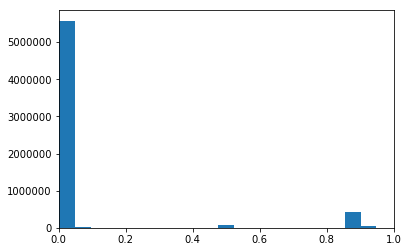

In [32]:
fig, ax = plt.subplots()
ax.hist([
    pred[0] for pred in window_predictions_everything
], bins=20)
ax.set_xlim(0, 1)
plt.show()

In [34]:
window_nums = [
    (video_id, intrvl.start, intrvl.end)
    for video_id in sorted(list(video_ids_all))
    for intrvl in windows_with_weak_labels.get_intervallist(video_id).get_intervals()
]

In [35]:
predictions_to_save_windows = [
    (window_info, prediction)
    for window_info, prediction in zip(window_nums, window_predictions_everything)
]

In [36]:
preds_np_windows = np.array(predictions_to_save_windows)

In [37]:
preds_np_windows.shape

(6175405, 2)

In [39]:
# save predictions to disk
with open('../../data/shot_detection_weak_labels/noisy_labels_all_windows_downsampled.npy', 'wb') as f:
    np.save(f, preds_np_windows)